In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp

import dickandballs as db
import helpers as hel

# chiral eft

In [4]:
def downsample_array(array, target_size):
    """
    Downsample an array to the target size and return the downsampled array and the corresponding indices.
    
    Parameters:
    - array: The input array to downsample.
    - target_size: The target size for the downsampled array.

    Returns:
    - downsampled_array: The downsampled array.
    - indices: The indices used for downsampling.
    """
    total_size = len(array)
    indices = np.linspace(0, total_size - 1, target_size, dtype=int)
    downsampled_array = array[indices]
    return downsampled_array, indices

In [5]:
ceft_lower= np.loadtxt('EOS/ceft/eos_ceft_lower.dat')
n_ceft_lower, p_ceft_lower, e_ceft_lower = ceft_lower.T

ceft_upper= np.loadtxt('EOS/ceft/eos_ceft_upper.dat')
n_ceft_upper, p_ceft_upper, e_ceft_upper = ceft_upper.T

n_ceft = n_ceft_lower/0.16 #n_sat

e_ceft = (e_ceft_lower+e_ceft_upper)/2
p_ceft = (p_ceft_lower+p_ceft_upper)/2


In [4]:
# downsampling
"""p_ceft_upper, downed_indices = downsample_array(p_ceft_upper, 50)
p_ceft_lower = p_ceft_lower[downed_indices]

e_ceft_upper = e_ceft_upper[downed_indices]
e_ceft_lower = e_ceft_lower[downed_indices]

n_ceft = n_ceft[downed_indices]

e_ceft = e_ceft[downed_indices]
p_ceft = p_ceft[downed_indices]"""


'p_ceft_upper, downed_indices = downsample_array(p_ceft_upper, 50)\np_ceft_lower = p_ceft_lower[downed_indices]\n\ne_ceft_upper = e_ceft_upper[downed_indices]\ne_ceft_lower = e_ceft_lower[downed_indices]\n\nn_ceft = n_ceft[downed_indices]\n\ne_ceft = e_ceft[downed_indices]\np_ceft = p_ceft[downed_indices]'

excluding the crust (n=0.076 fm^-3) because the uncertainty in the crust is way to low and that strongly influences how the gpr behaves (it conditions on the crust too heavily)

In [6]:
n_crust = n_ceft[:111]
e_crust = e_ceft[:111]
p_crust = p_ceft[:111]


p_ceft_upper = p_ceft_upper[111:]
p_ceft_lower = p_ceft_lower[111:]

e_ceft_upper = e_ceft_upper[111:]
e_ceft_lower = e_ceft_lower[111:]

n_ceft = n_ceft[111:]
e_ceft = e_ceft[111:]
p_ceft = p_ceft[111:]
mu_ceft = (e_ceft + p_ceft)/n_ceft

e_ini = e_ceft[0]
p_ini = p_ceft[0]
n_ini = n_ceft[0]
mu_ini = (e_ini + p_ini) / n_ini

e_crust_width = e_ceft_upper[0] - e_ceft_lower[0]
e_ini_sigma = hel.CI_to_sigma(e_crust_width, 75)

p_crust_width = p_ceft_upper[0] - p_ceft_lower[0]
p_ini_sigma = hel.CI_to_sigma(p_crust_width, 75)

mu_ini_sigma = e_ini_sigma + p_ini_sigma

In [7]:
(e_crust[-1] + p_crust[-1])/ n_crust[-1]

151.16331486186536

In [8]:
mu_ini

151.16999723481618

In [9]:
cs2_ceft_lower = np.gradient(p_ceft_lower, e_ceft_lower) #dp/de
cs2_ceft_upper = np.gradient(p_ceft_upper, e_ceft_upper) #dp/de
cs2_ceft_avg = (cs2_ceft_upper+cs2_ceft_lower)/2
cs2_ceft_width = cs2_ceft_upper-cs2_ceft_lower
cs2_ceft_sigma = hel.CI_to_sigma(cs2_ceft_width, 75)

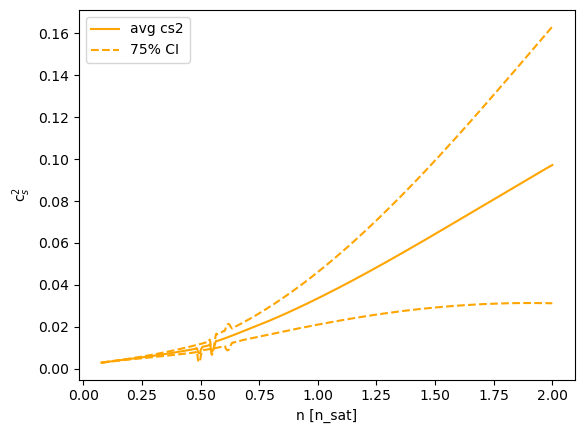

In [10]:
plt.plot(n_ceft, cs2_ceft_avg, color='orange', label='avg cs2')

plt.plot(n_ceft, cs2_ceft_avg+cs2_ceft_width/2, '--', color='orange', label='75% CI')
plt.plot(n_ceft, cs2_ceft_avg-cs2_ceft_width/2, '--', color='orange')


plt.ylabel(r'c$_s^2$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()



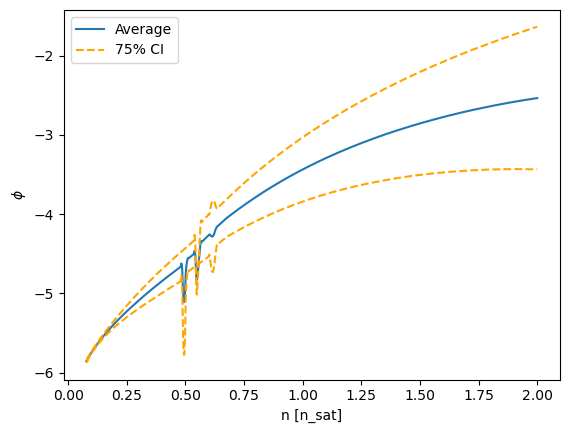

In [11]:
phi_ceft_lower = hel.get_phi(cs2_ceft_lower)
phi_ceft_upper = hel.get_phi(cs2_ceft_upper)
phi_ceft_width = phi_ceft_upper-phi_ceft_lower
phi_ceft_avg = (phi_ceft_upper+phi_ceft_lower)/2
phi_ceft_sigma = hel.CI_to_sigma(phi_ceft_width, 75)

plt.plot(n_ceft, phi_ceft_avg, label='Average')
plt.plot(n_ceft, phi_ceft_lower, "--", color='orange')
plt.plot(n_ceft, phi_ceft_upper, "--", color='orange', label='75% CI')
plt.ylabel(r'$\phi$')
plt.xlabel('n [n_sat]')
plt.legend()
plt.show()


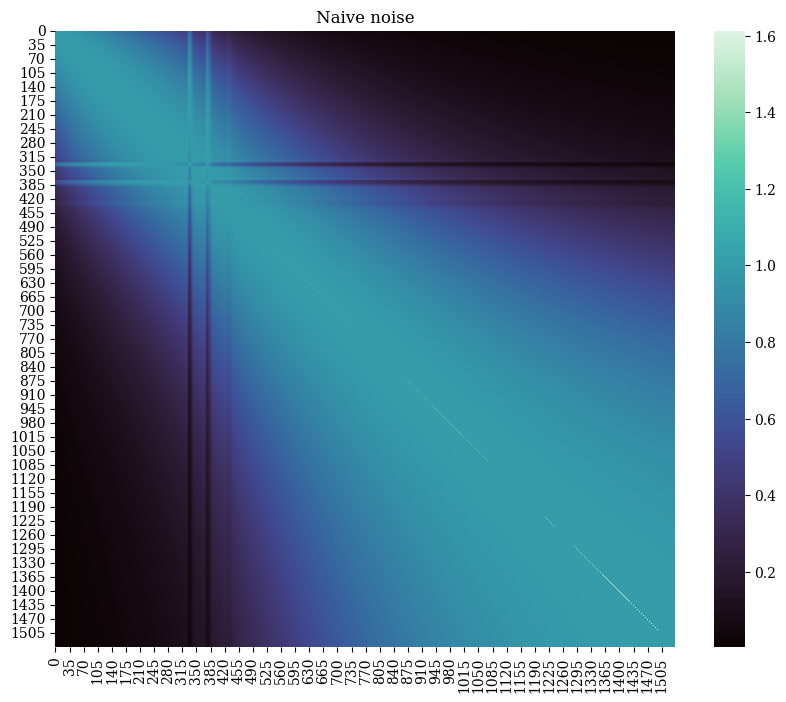

In [116]:
kern = db.Kernel('SE', sigma = 1, l = 1)
K11 = kern.compute(phi_ceft_avg)

noise_kern = K11 + np.diag(phi_ceft_sigma**2)
kern.visualise_kernel(noise_kern, 'Naive noise', annotation=False)


# GPR

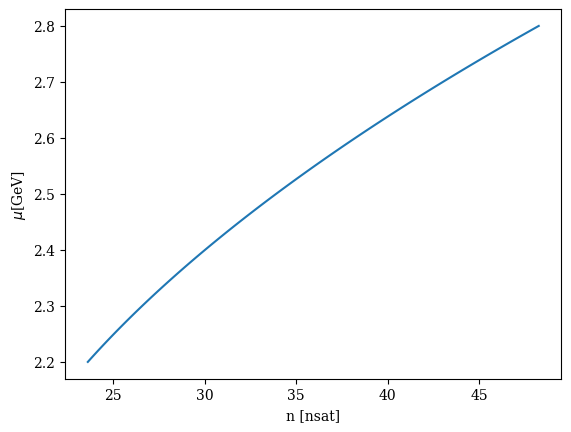

In [12]:
from scipy.integrate import cumulative_simpson as cumsimp

integrand_pqcd = cs2_pqcd / n_pqcd
integral_pqcd = cumsimp(y=integrand_pqcd, x=n_pqcd, initial=0)

mu_pqcd = 2.2*np.exp(integral_pqcd) #self.mu_0 * np.exp(integral)

plt.plot(n_pqcd, mu_pqcd)
plt.xlabel("n [nsat]")
plt.ylabel("$\mu$[GeV]")
plt.show()

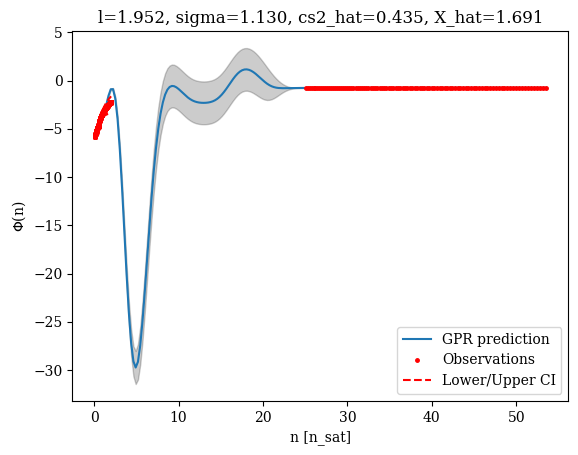

In [14]:
cs2_hat, nu_hat, l_hat, X_hat = hel.get_hype_samples()

kernel = db.Kernel('SE', sigma=nu_hat, l=l_hat)

n_pqcd, cs2_pqcd = hel.get_pqcd(X_hat, size=100)

x_train =  np.concatenate((n_ceft, n_pqcd))
cs2_train =  np.concatenate((cs2_ceft_avg, cs2_pqcd))

phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
phi_sigma_train = np.concatenate((phi_ceft_sigma, phi_pqcd_sigma))
phi_train = hel.get_phi(cs2_train)
train_noise = phi_sigma_train**2

x_test = np.linspace(n_ceft[0], n_pqcd[-1], 200) # number density, starting val is ending val of n crust


gp = db.GP(kernel, hel.get_phi(cs2_hat))
gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()


plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\Phi$(n)')
plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}, X_hat={X_hat:.3f}")

plt.plot(n_ceft, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n_ceft, phi_ceft_avg-phi_ceft_width/2, '--', color='red')


plt.legend()
plt.show()



# eos uncertainties

$$c_s^2 = \frac{1}{e^{-\phi}+1}$$ 
$$\sigma_{c_s^2} = |\frac{\partial {c_s^2}}{\partial \phi}| \sigma_{\phi} = \frac{e^{-\phi}}{(e^{-\phi}+1)^2}| \sigma_{\phi}$$

In [156]:
eos = db.EosProperties(x_test, phi_test, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini)
eos_prop_results = eos.get_all()

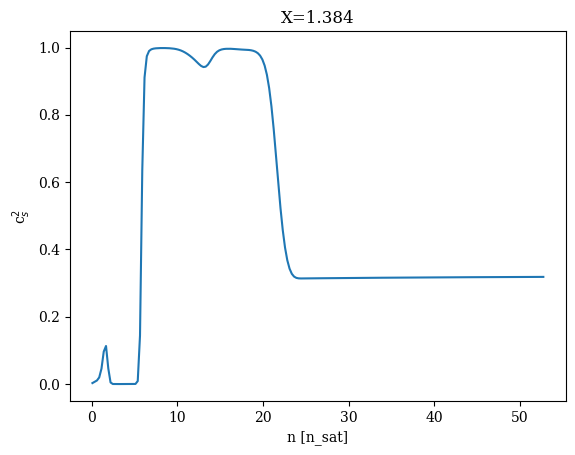

In [157]:
plt.plot(x_test, eos_prop_results['cs2'])
plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.title(f"X={X_hat:.3f}")
plt.show()

In [13]:
def cs2_uncertainty(phi, sig_phi):
    phi = phi.flatten()
    sig_cs2 = np.abs(np.exp(-phi)/((np.exp(-phi)+1)**2)) * sig_phi
    return sig_cs2

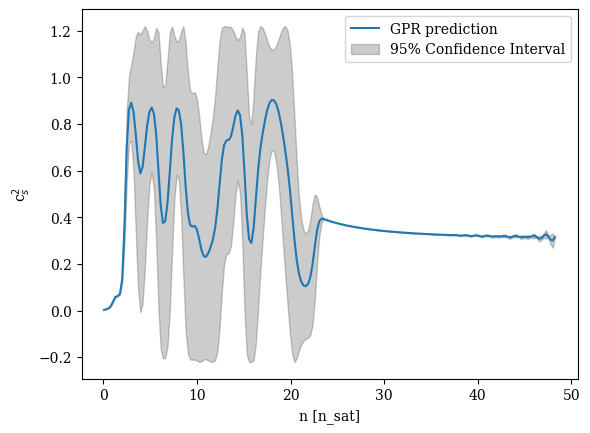

In [19]:
sig_cs2 = cs2_uncertainty(phi_test, sig)
plt.plot(x_test, eos_prop_results['cs2'], label='GPR prediction')
plt.fill_between(x_test, eos_prop_results['cs2'] - 1.96 * sig_cs2, eos_prop_results['cs2'] + 1.96 * sig_cs2, alpha=0.2, color='k', label='95% Confidence Interval')
plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.legend()

plt.show()

In [16]:
def mu_uncertainty(mu, mu0, sig_mu0, sig_cs2, n, n_init):
    """
    Calculate the uncertainty in mu (sigma_mu).

    Parameters:
    - mu: Array of mu values.
    - sig_cs2: Array of uncertainties in c_i^2 (sigma_c_i).
    - x_test: Array of n_i values.
    - delta_n: Array of Delta n_i values corresponding to each n_i.

    Returns:
    - sigma_mu: Array of uncertainties in mu (sigma_mu).

    See notebook on uncertainty
    """
    # Ensure all inputs are numpy arrays for efficient calculations
    mu = np.array(mu)
    sig_cs2 = np.array(sig_cs2)
    n = np.array(n)
    delta_n = np.diff(n, prepend=n_init)

    uncertainty_terms = (delta_n / n) * sig_cs2

    sigma_x2 = np.sum(uncertainty_terms**2)
    
    # Compute sigma_mu using the propagated uncertainty formula
    sigma_mu = ((mu*sigma_x2)+(sig_mu0 * mu/mu0))**0.5
    
    return sigma_mu


In [17]:
sig_mu = mu_uncertainty(eos_prop_results['mu'], mu_ini, mu_ini_sigma, sig_cs2, x_test, n_ini)

In [170]:
cs2_at_pqcd = eos_prop_results["cs2"][94:]
n_at_pqcd = x_test[94:]
from scipy.integrate import cumulative_trapezoid as cumtrap
integrand_at_pqcd = cs2_at_pqcd/n_at_pqcd
mu_at_pqcd = 2200*np.exp(cumtrap(y = integrand_at_pqcd, x= n_at_pqcd, initial=0))

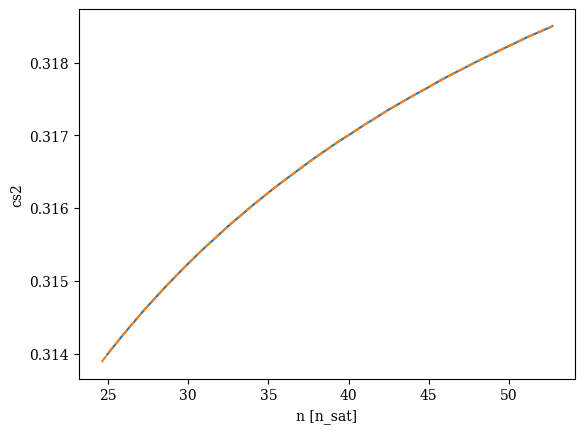

In [171]:
plt.plot(n_at_pqcd, cs2_at_pqcd, label='GPR prediction')
plt.plot(n_pqcd, cs2_pqcd, "--", label = 'pQCD')
plt.xlabel('n [n_sat]')
plt.ylabel('cs2')
plt.show()

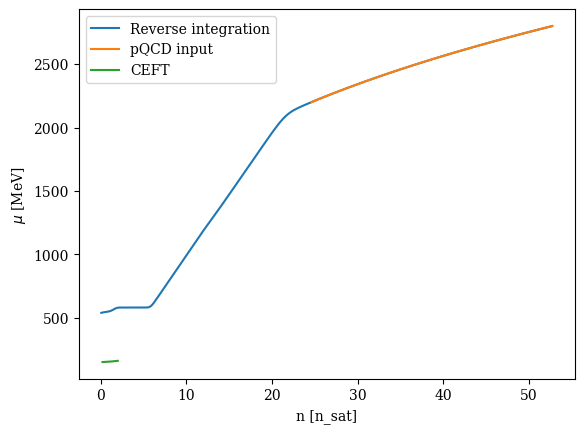

In [240]:
import numpy as np
from scipy.integrate import cumulative_trapezoid as cumtrapz
import matplotlib.pyplot as plt

# Reverse x and y before integrating
x_test_rev = x_test[::-1]

int_all = eos_prop_results["cs2"]/x_test
int_all_rev = int_all[::-1] 

# Compute the integral with a sign flip to compensate for the reversed x
integral = cumtrapz(int_all_rev, x_test_rev, initial=0)

# Reverse the result back to match the original order
integral_rev = integral[::-1]

# Compute mu_all using the correctly ordered integral
mu_all = 2800 * np.exp(integral_rev)

# Plot results
plt.plot(x_test, mu_all, label='Reverse integration')
plt.plot(n_pqcd, mu_grid*1000, label="pQCD input")
plt.plot(n_ceft, mu_ceft, label="CEFT")

plt.xlabel('n [n_sat]')
plt.ylabel(r'$\mu$ [MeV]')
plt.legend()
plt.show()


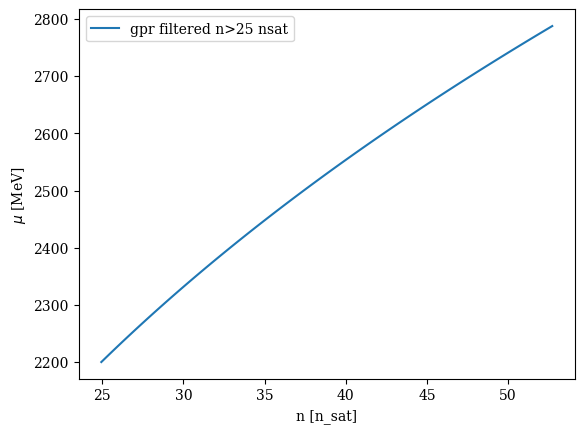

In [178]:
from pqcd.pQCD import pQCD

cs2_at_pqcd = eos_prop_results["cs2"][94:]
n_at_pqcd = x_test[94:]
from scipy.integrate import cumulative_trapezoid as cumtrap
integrand_at_pqcd = cs2_at_pqcd/n_at_pqcd
mu_at_pqcd = 2200*np.exp(cumtrap(y = integrand_at_pqcd, x= n_at_pqcd, initial=0))


mu_grid = np.linspace(2.2,2.8,100) #Grid in chemical potential in [GeV]

pQCD = pQCD(X_hat)
n_pQCD = np.vectorize(pQCD.number_density)(mu_grid)/0.16

#plt.plot(n_pQCD, mu_grid*1000, label = 'pQCD calculation')
plt.plot(n_at_pqcd, mu_at_pqcd, label='gpr filtered n>25 nsat')

plt.xlabel("n [n_sat]")
plt.ylabel("$\mu$ [MeV]")
plt.legend()
plt.show()

In [231]:
mu_all[0]/3

179.9044673957351

In [229]:
eos_prop_results['mu'][0]

151.16999723481618

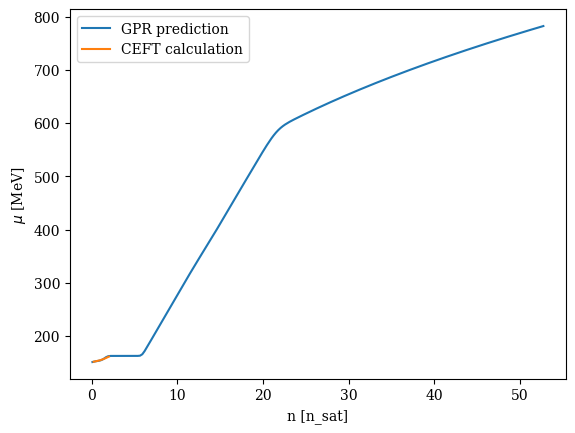

In [236]:
plt.plot(x_test, eos_prop_results['mu'], label='GPR prediction')
#plt.fill_between(x_test, eos_prop_results['mu'] - 1.96 * sig_mu, eos_prop_results['mu'] + 1.96 * sig_mu, alpha=0.2, color='k', label='95% Confidence Interval')
#plt.plot(n_at_pqcd, mu_at_pqcd, label='GPR filtered: n>25nsat')

#plt.plot(n_pqcd, mu_grid*1000, label = "pQCD input")
#plt.plot(x_test[94:], 3*eos_prop_results["mu"][94:], label= "3$\mu$ after n>25")
plt.plot(n_ceft, mu_ceft, label="CEFT calculation")
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\mu$ [MeV]')
plt.legend()
plt.show()



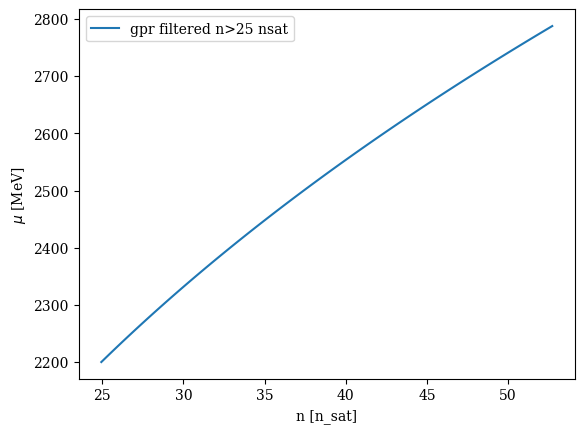

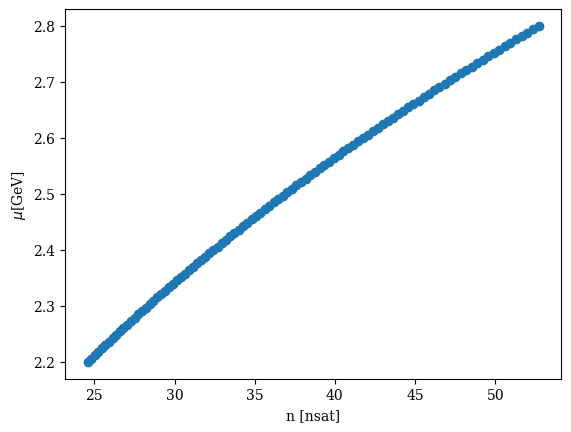

In [174]:
from scipy.integrate import cumulative_simpson as cumsimp

integrand_pqcd = cs2_pqcd / n_pqcd
integral_pqcd = cumsimp(y=integrand_pqcd, x=n_pqcd, initial=0)

mu_pqcd = 2.2*np.exp(integral_pqcd) #self.mu_0 * np.exp(integral)

plt.scatter(n_pqcd, mu_pqcd)
plt.plot(n_pQCD, mu_grid)

plt.xlabel("n [nsat]")
plt.ylabel("$\mu$[GeV]")
plt.show()

In [304]:
from scipy.integrate import solve_bvp


cs2 = eos_prop_results["cs2"]
n = x_test

# Define the ODE system
def ode(n, y, cs2):
    mu = y[0]  # y[0] represents mu
    dydn = [mu * cs2 / n]  # First-order differential equation
    return dydn

# Define the boundary conditions
def bc(y_low, y_high, mu_0, mu_final):
    return [y_low[0] - mu_0,  # At the first point, mu = mu_0
            y_high[0] - mu_final]  # At the last point, mu = mu_final

# Inputs
mu_0 = 151  # Initial value of mu at n=0.08
mu_final = 2800  # Final value of mu at n=50

# Initial guess for mu (linear interpolation between mu_0 and mu_final)
mu_guess = np.linspace(mu_0, mu_final, n.size)

# Solve the BVP
solution = solve_bvp(lambda n, y: ode(n, y, np.interp(n, n, cs2)),  # Interpolate cs2
                     lambda y_low, y_high: bc(y_low, y_high, mu_0, mu_final),
                     n,  # n points
                     [mu_guess])  # Initial guess

# Extract the solution
mu_bvp = solution.sol(n)[0]

# Plot the result
import matplotlib.pyplot as plt
plt.plot(n, mu_bvp, label="BVP Solution")
plt.xlabel("n [n_sat]")
plt.ylabel("μ [MeV]")
plt.legend()
plt.show()


ValueError: `bc` return is expected to have shape (1,), but actually has (2,).

In [61]:
from scipy.integrate import cumulative_simpson as cumsimp

def integrate_mu(cs2, n, mu_0, mu_final):
    """
    Perform numerical integration of cs2 / n and compute mu using the initial and final values of mu.
    
    Parameters:
    cs2 (array): Array of cs2 values.
    n (array): Array of n values.
    mu_0 (float): Initial value of mu.
    mu_final (float): Final value of mu.
    
    Returns:
    array: Integrated values of mu.
    """
    integrand = cs2 / n
    integral = cumsimp(y=integrand, x=n, initial=0)

    mu = mu_0 * np.exp(integral)

    # Adjust the final value of mu to match mu_final
    mu_adjusted = mu * (mu_final / mu[-1])
    return mu_adjusted

In [103]:
import numpy as np
from scipy.integrate import odeint

def integrate_mu_with_constraints(cs2, n, mu_0, mu_final):
    """
    Integrates the differential equation for mu(n) while satisfying both the initial condition mu(n[0]) = mu_0
    and the final condition mu(n[-1]) = mu_final.
    
    The differential equation is assumed to be:
        d(mu)/dn = (cs2(n)/n) * mu
    where cs2 is given as an array corresponding to each value in n.

    Parameters:
      cs2 (array): Array of cs2 values (same length as n).
      n (array): Array of n values (strictly increasing).
      mu_0 (float): Initial value of mu at n[0].
      mu_final (float): Final value of mu at n[-1].

    Returns:
      array: Integrated values of mu across n.
    """

    # To handle cs2 properly, we interpolate it in case odeint calls the derivative function
    # at n values that are not exactly in the array.
    cs2_interp = lambda n_val: np.interp(n_val, n, cs2)

    # Define the forward ODE: d(mu)/dn = (cs2(n)/n)*mu
    def dmu_dn(mu, n_val):
        # mu is an array with one element, so return an array of the same shape
        return [(cs2_interp(n_val) / n_val) * mu[0]]

    # Forward integration from n[0] to n[-1]
    # Wrap the initial condition in a list to satisfy odeint's expectation.
    forward_solution = odeint(dmu_dn, [mu_0], n).flatten()

    # Define the reverse ODE: d(mu)/dn = -(cs2(n)/n)*mu for backward integration.
    def dmu_dn_reverse(mu, n_val):
        # Return an array of the same shape as mu
        return [-(cs2_interp(n_val) / n_val) * mu[0]]

    # Backward integration from n[-1] to n[0]
    backward_solution = odeint(dmu_dn_reverse, [mu_final], n[::-1]).flatten()[::-1]

    # Blend the two solutions. For example, use linear weights from 0 to 1:
    #weights = np.linspace(0, 1, len(n))
    #mu_combined = (1 - weights) * forward_solution + weights * backward_solution
    weights = 1 / (1 + np.exp(-10 * (n - n[len(n) // 2])))
    mu_combined = (1 - weights) * forward_solution + weights * backward_solution

    plt.plot(n, forward_solution, label="Forward Solution")
    plt.plot(n, backward_solution[::-1], label="Backward Solution")
    plt.legend()
    plt.show()

    return mu_combined


In [100]:
mu_ceft = (e_ceft+p_ceft)/n_ceft

In [53]:
def epsilon_uncertainty(epsilon, sigma_epsilon0, sigma_mu, n, n_init):
    n = np.array(n)
    delta_n = np.diff(n, prepend=n_init)

    cumulative_uncertainty_squared = 0.0
    sigma_epsilon = np.zeros(len(epsilon))

    for i in range(len(epsilon)):
        cumulative_uncertainty_squared += (sigma_mu[i] * delta_n[i])**2
        sigma_epsilon[i] = np.sqrt(sigma_epsilon0**2 + cumulative_uncertainty_squared)

    return sigma_epsilon

In [54]:
sig_epsilon = epsilon_uncertainty(eos_prop_results['epsilon'], e_ini, sig_mu, x_test, n_ini)

In [55]:
def sigma_cov(x,y):
    n = len(x)
    sig = 1/n * np.sum((x-np.mean(x))*(y-np.mean(y)))
    return sig

In [56]:
sigma_cov(eos_prop_results["cs2"], eos_prop_results["mu"])

-6.525684784661569

In [57]:
from scipy.integrate import cumulative_simpson as cumsimp

def p_uncertainty(p0, sigma_p0, p, epsilon, epsilon_0, mu, mu_0, sigma_mu, cs2, sigma_cs2, n):
    """
    Calculate the propagated uncertainty in p = p0 + integral(cs2 * mu dn).

    Parameters:
    - p0: Initial value of p.
    - sigma_p0: Uncertainty in p0.
    - p: Array of precomputed p values.
    - epsilon: Array of cumulative integral values for mu (epsilon).
    - epsilon_0: Initial value of epsilon (epsilon_0).
    - mu: Array of mu values.
    - mu_0: Initial value of mu.
    - sigma_mu: Array of uncertainties in mu.
    - cs2: Array of cs2 values.
    - sigma_cs2: Array of uncertainties in cs2.
    - n: Array of n values (integration variable).

    Returns:
    - sigma_p: Uncertainty in p.
    """
    # Calculate integrals from the given data
    integral_cs2_mu = p - p0  # Integral of cs2 * mu (already computed as p - p0)
    integral_mu = epsilon - epsilon_0  # Integral of mu (from epsilon)
    integral_cs2 = cumsimp(y=cs2, x=n, initial=np.log(mu_0))  # Integral of cs2

    # Partial derivatives
    partial_mu = integral_cs2  # ∂p/∂mu = ∫cs2 dn
    partial_cs2 = integral_mu  # ∂p/∂cs2 = ∫mu dn

    sigma_cs2_mu = sigma_cov(cs2, mu)

    # Propagate uncertainty
    sigma_p_squared = (
        sigma_p0**2 +                               # Contribution from p0
        (partial_mu**2) * sigma_mu**2 +             # Contribution from mu
        (partial_cs2**2) * sigma_cs2**2 +           # Contribution from cs2 <- largest
        2 * np.abs(partial_mu * partial_cs2) * (sigma_mu*sigma_cs2) # Covariance term, note it is the upper bound
    )
    sigma_p = np.sqrt(sigma_p_squared)

    return sigma_p


In [58]:
sig_p = p_uncertainty(p_ini, 
                      p_ini_sigma, 
                      eos_prop_results["pressure2"], 
                      eos_prop_results["epsilon"], 
                      e_ini, 
                      eos_prop_results["mu"], 
                      mu_ini, 
                      mu_ini_sigma, 
                      eos_prop_results["cs2"], 
                      sig_cs2, 
                      x_test)

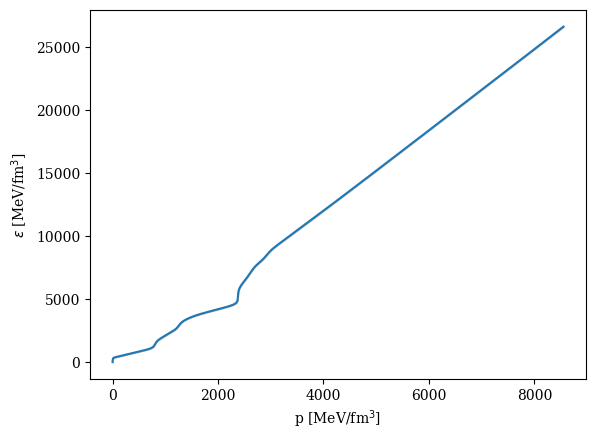

In [59]:
plt.plot( eos_prop_results["pressure2"], eos_prop_results["epsilon"],)
plt.ylabel(r'$\epsilon$ [MeV/fm$^3$]')
plt.xlabel(r'p [MeV/fm$^3$]')

plt.fill_between(eos_prop_results["pressure2"], eos_prop_results['epsilon'] - 1.96 * sig_epsilon, eos_prop_results['epsilon'] + 1.96 * sig_epsilon, alpha=0.2, color='k', label='95% Confidence Interval')

plt.show()    

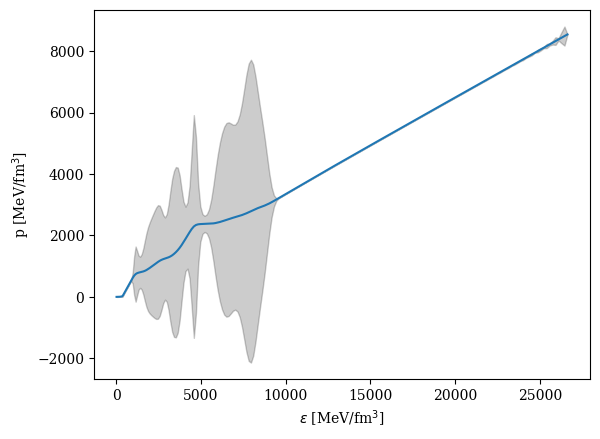

In [60]:
plt.plot(eos_prop_results["epsilon"], eos_prop_results["pressure2"])
plt.xlabel(r'$\epsilon$ [MeV/fm$^3$]')
plt.ylabel(r'p [MeV/fm$^3$]')

plt.fill_between(eos_prop_results["epsilon"], eos_prop_results['pressure2'] - 1.96 * sig_p, eos_prop_results['pressure2'] + 1.96 * sig_p, alpha=0.2, color='k', label='95% Confidence Interval')

plt.show()    